In [1]:
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.layers as L
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 

In [2]:
class TrainingConfig():
    epochs = 5
    batch_size= 128
    learningRate=0.001
    valRate=0.1
    loss=['sparse_categorical_crossentropy']
    metrics=['accuracy']
    optimizer='adam'
    
class WordEmbedding():
    sequenceLength=256
    wordCount=10000
    wordDim=10

class DataSourceConfig():
    source=["./dataset/imdb_train_data.npy",
           "./dataset/imdb_test_data.npy",
           "./dataset/imdb_train_labels.npy",
           "./dataset/imdb_test_labels.npy"]

In [79]:
class AttentionLayer(L.Layer):
    def __init__(self,output_dim,**kwargs):
        self.output_dim=output_dim
        super(AttentionLayer,self).__init__(**kwargs)
        
    def build(self,input_shape):
        self.kernel=self.add_weight(name='kernel',shape=(input_shape[2],1),
                                   initializer='uniform',
                                    trainable=True
                                   )
        super(AttentionLayer,self).build(input_shape)
        
    def call(self,h):
        M=L.Activation("tanh")(h)
        a=tf.matmul(self.kernel,M,transpose_a=True,transpose_b=True)
        a=L.Activation("softmax")(a)
        r=tf.matmul(a,h)
        h_=L.Activation("tanh")(r)
        # 天坑,不加这个识别不出来形状
        h_=tf.squeeze(h_,1)
        return h_
        
    def compute_output_shape(self,input_shape):
        return (input_shape[0],self.output_dim)

In [80]:
class Bi_LSTM_Attention():
    def __init__(self,config,wordEmbedding):
        
        self.model = None
        self.history = None
        self.config=config
        self.emb=wordEmbedding
        self.name="Bi_LSTM_Attention"
    
    def design_model(self,hiden_size=32,with_fc=False):
        input_layer=L.Input(shape=(self.emb.sequenceLength,),name='feature_input')
        w=L.Embedding(input_dim=self.emb.wordCount,output_dim=self.emb.wordDim,input_length=self.emb.sequenceLength)(input_layer)
        x=w
        x=L.Bidirectional(L.LSTM(hiden_size,dropout=0.4,return_sequences=True),merge_mode='sum')(x)

        #与x的最后一层一致
        x=AttentionLayer(hiden_size)(x)
        
        if with_fc:
            x=L.Dense(hiden_size,activation='relu')(x)
        
        output_layer=L.Dense(2,activation='softmax')(x)
        model=K.models.Model(inputs=[input_layer],outputs=[output_layer],name=self.name)
        self.model=model
        model.summary()
        return model
    
    
    def compile_model(self):
        #assert()
        if not self.model:
            print("Call design_modelXX() to build the model first.")
            return
        self.model.compile(optimizer=self.config.optimizer,loss=self.config.loss,metrics=self.config.metrics)

    def train_model(self,x,y):
        if not self.model:
            print("Call design_modelXX() to build the model first.")
            return
        self.compile_model()
        self.history=self.model.fit(x=x,y=y,batch_size=self.config.batch_size,epochs=self.config.epochs,validation_split=self.config.valRate)
        #self.model.compile()
    
    def save_model(self):
        if not self.model:
            print("Call design_modelXX() to build the model first.")
        pass
    
    def eval_model(self):
        if not self.model:
            print("Call design_modelXX() to build the model first.")
        pass
    
    def view_train(self):
        if not self.history:
            print("Model has not been trained, train it first")
            return
        
        train=self.history.history["loss"]
        valid=self.history.history["val_loss"]
        name='loss'
        plt.title('The %s with epoch runs'%name,fontsize=30)
        plt.xlabel('epoch',fontsize=20)
        plt.ylabel(name,fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.plot(train,label=name)
        plt.plot(valid,label="val_"+name)
        plt.legend()
        plt.gcf().set_size_inches(15,4)
        plt.show()
    #model=K.models.Model(inputs=[input_layer],outputs=[output_layer])
    #model.compile('adam',loss='categorical_crossentropy',metrics=metrics)
    #return model

In [81]:
train_config=TrainingConfig()
word_embedding=WordEmbedding()
model=Bi_LSTM_Attention(train_config,word_embedding)

In [82]:
model.design_model(with_fc=False)

Model: "Bi_LSTM_Attention"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 256, 10)           100000    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256, 32)           11008     
_________________________________________________________________
attention_layer_20 (Attentio (None, 32)                32        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total params: 111,106
Trainable params: 111,106
Non-trainable params: 0
_________________________________________________________________


In [83]:
class Dataset():
    def __init__(self,config):
        self.config=config
    def load(self):
        L=[]
        for item in self.config.source:
            L.append(np.load(item,allow_pickle=True, fix_imports=True))
        return L

In [84]:
data=Dataset(DataSourceConfig)
train_data,test_data,train_labels,test_labels=data.load()

In [85]:
model.train_model(x=train_data,y=train_labels)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 7s 294us/sample - loss: 0.5445 - accuracy: 0.7127 - val_loss: 0.3811 - val_accuracy: 0.8580
Epoch 2/5
22500/22500 [==============================] - 5s 214us/sample - loss: 0.2938 - accuracy: 0.8836 - val_loss: 0.3134 - val_accuracy: 0.8672
Epoch 3/5
22500/22500 [==============================] - 6s 276us/sample - loss: 0.2228 - accuracy: 0.9140 - val_loss: 0.3145 - val_accuracy: 0.8844
Epoch 4/5
22500/22500 [==============================] - 4s 199us/sample - loss: 0.1868 - accuracy: 0.9307 - val_loss: 0.3113 - val_accuracy: 0.8852
Epoch 5/5
22500/22500 [==============================] - 7s 296us/sample - loss: 0.1603 - accuracy: 0.9429 - val_loss: 0.3558 - val_accuracy: 0.8752


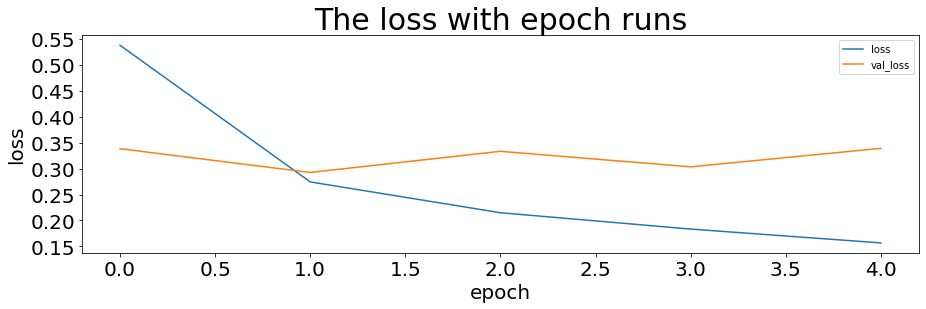

In [78]:
model.view_train()